In [4]:
import pandas as pd
import numpy as np


In [ ]:
#TRAINING DATASET DATA CLEANING

In [6]:
nfl_data = pd.read_excel('Training_Data-1.xlsx')


In [8]:
nfl_data.dtypes

DATE                                                                 datetime64[ns]
WEEK#                                                                         int64
PLAY-ID                                                                       int64
DRIVE-ID                                                                      int64
QUARTER                                                                       int64
REMAINING TIME IN THE QUARTER (mm:ss)                                        object
DOWN                                                                        float64
TO GO                                                                         int64
YARD LINE 0-100                                                               int64
OFFENSIVE TEAM                                                               object
DEFENSIVE TEAM                                                               object
OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral                              

In [10]:
# Check for missing values in each column
missing_values = nfl_data.isnull().sum()

# Display columns with missing values
columns_with_missing = missing_values[missing_values > 0]
print("Columns with missing values:\n", columns_with_missing)


Columns with missing values:
 DOWN                               121
POINTS SCORED\nBY EITHER TEAM    32590
YARDS GAINED                      8013
dtype: int64


In [12]:
columns_to_drop = ['POINTS SCORED\nBY EITHER TEAM', 'YARDS GAINED', 'PLAY-ID', 'DRIVE-ID', 'DATE', 'WEEK#']
nfl_data.drop(columns=columns_to_drop, inplace=True)


In [14]:
# Drop rows with missing values in the 'DOWN' column
nfl_data.dropna(subset=['DOWN'], inplace=True)

# Display the updated dataset (showing the first few rows)
print(nfl_data.head())

# Optionally, check if there are still missing values in the 'DOWN' column
missing_in_down = nfl_data['DOWN'].isnull().sum()
print(f"Missing values in 'DOWN' column after dropping rows: {missing_in_down}")


   QUARTER REMAINING TIME IN THE QUARTER (mm:ss)  DOWN  TO GO  \
0        1                              15:00:00   1.0     10   
1        1                              14:29:00   2.0      3   
2        1                              14:25:00   3.0      3   
3        1                              14:09:00   1.0     10   
4        1                              13:34:00   2.0      5   

   YARD LINE 0-100 OFFENSIVE TEAM DEFENSIVE TEAM  \
0               75            DET             KC   
1               68            DET             KC   
2               68            DET             KC   
3               87             KC            DET   
4               82             KC            DET   

  OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral  \
0                                           Road   
1                                           Road   
2                                           Road   
3                                           Home   
4                                   

In [22]:
# Function to detect outliers using the IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Identify numerical columns
numerical_columns = nfl_data.select_dtypes(include=['float64', 'int64']).columns

# Check for outliers in all numerical columns
outliers_summary = {}
for column in numerical_columns:
    outliers = detect_outliers_iqr(nfl_data, column)
    outliers_summary[column] = len(outliers)

# Convert the summary into a DataFrame for better visualization
outliers_df = pd.DataFrame(list(outliers_summary.items()), columns=['Column', 'Number of Outliers'])

# Display the DataFrame
print(outliers_df)


                                              Column  Number of Outliers
0                                            QUARTER                   0
1                                               DOWN                 793
2                                              TO GO                1113
3                                    YARD LINE 0-100                   0
4                      ROAD TEAM'S ACCUMULATED SCORE                 277
5                      HOME TEAM'S ACCUMULATED SCORE                 346
6  SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n...                1756


In [24]:
# Function to handle outliers using capping
def cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap the outliers
    data[column] = data[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

# Handle outliers for columns with significant outliers
for column in numerical_columns:
    if outliers_summary[column] > 0:  # If there are outliers
        cap_outliers(nfl_data, column)

# Verify changes by re-checking for outliers
updated_outliers_summary = {}
for column in numerical_columns:
    outliers = detect_outliers_iqr(nfl_data, column)
    updated_outliers_summary[column] = len(outliers)

# Convert the updated summary into a DataFrame
updated_outliers_df = pd.DataFrame(list(updated_outliers_summary.items()), columns=['Column', 'Number of Outliers After Capping'])

# Display the updated outliers summary
print(updated_outliers_df)


                                              Column  \
0                                            QUARTER   
1                                               DOWN   
2                                              TO GO   
3                                    YARD LINE 0-100   
4                      ROAD TEAM'S ACCUMULATED SCORE   
5                      HOME TEAM'S ACCUMULATED SCORE   
6  SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n...   

   Number of Outliers After Capping  
0                                 0  
1                                 0  
2                                 0  
3                                 0  
4                                 0  
5                                 0  
6                                 0  


In [26]:
# Preprocess the time column to ensure all values are strings
nfl_data['REMAINING TIME IN THE QUARTER (mm:ss)'] = nfl_data['REMAINING TIME IN THE QUARTER (mm:ss)'].astype(str)

# Define a function to safely convert time to seconds
def convert_to_seconds(time_str):
    try:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        return None  # Return None if the format is incorrect

# Apply the function to convert time to seconds
nfl_data['Time in Seconds'] = nfl_data['REMAINING TIME IN THE QUARTER (mm:ss)'].apply(convert_to_seconds)

# Drop the original time column if no longer needed
nfl_data.drop(columns=['REMAINING TIME IN THE QUARTER (mm:ss)'], inplace=True)

# Display the updated dataset
nfl_data.head()


,QUARTER,DOWN,TO GO,YARD LINE 0-100,OFFENSIVE TEAM,DEFENSIVE TEAM,"OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral",ROAD TEAM'S ACCUMULATED SCORE,HOME TEAM'S ACCUMULATED SCORE,SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score),Play_Type,Time in Seconds
0,1,1.0,10.0,75,DET,KC,Road,0.0,0.0,0.0,Run,None
1,1,2.0,3.0,68,DET,KC,Road,0.0,0.0,0.0,Pass,None
2,1,3.0,3.0,68,DET,KC,Road,0.0,0.0,0.0,Pass,None
3,1,1.0,10.0,87,KC,DET,Home,0.0,0.0,0.0,Run,None
4,1,2.0,5.0,82,KC,DET,Home,0.0,0.0,0.0,Run,None


In [28]:
from sklearn.preprocessing import LabelEncoder

# Automatically detect all categorical columns
categorical_columns = nfl_data.select_dtypes(include=['object']).columns

# Exclude 'REMAINING TIME IN THE QUARTER (mm:ss)' if it exists
categorical_columns = [col for col in categorical_columns if col != 'REMAINING TIME IN THE QUARTER (mm:ss)']

# Apply LabelEncoder to each remaining categorical column
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    nfl_data[column] = le.fit_transform(nfl_data[column].astype(str))
    label_encoders[column] = le  # Store the encoder for potential inverse transformation or reuse

# Display the updated dataset
nfl_data.head()


,QUARTER,DOWN,TO GO,YARD LINE 0-100,OFFENSIVE TEAM,DEFENSIVE TEAM,"OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral",ROAD TEAM'S ACCUMULATED SCORE,HOME TEAM'S ACCUMULATED SCORE,SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score),Play_Type,Time in Seconds
0,1,1.0,10.0,75,10,15,1,0.0,0.0,0.0,1,0
1,1,2.0,3.0,68,10,15,1,0.0,0.0,0.0,0,0
2,1,3.0,3.0,68,10,15,1,0.0,0.0,0.0,0,0
3,1,1.0,10.0,87,15,10,0,0.0,0.0,0.0,1,0
4,1,2.0,5.0,82,15,10,0,0.0,0.0,0.0,1,0


In [30]:
from sklearn.preprocessing import StandardScaler

# Manually specify the numerical columns
numerical_columns = ['DOWN', 'TO GO', 'YARD LINE 0-100', 'ROAD TEAM\'S ACCUMULATED SCORE', 
                     'HOME TEAM\'S ACCUMULATED SCORE', 
                     'SCORE\nDIFFERENTIAL\n(Home Team\'s Score) \n-\n(Road Team\'s Score)', 
                     'Time in Seconds']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the manually specified numerical columns
nfl_data[numerical_columns] = scaler.fit_transform(nfl_data[numerical_columns])

# Display the standardized dataset
nfl_data.head()


,QUARTER,DOWN,TO GO,YARD LINE 0-100,OFFENSIVE TEAM,DEFENSIVE TEAM,"OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral",ROAD TEAM'S ACCUMULATED SCORE,HOME TEAM'S ACCUMULATED SCORE,SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score),Play_Type,Time in Seconds
0,1,-0.997037,0.472407,0.983369,10,15,1,-1.125986,-1.165969,-0.129211,1,0.0
1,1,0.231303,-1.493104,0.693837,10,15,1,-1.125986,-1.165969,-0.129211,0,0.0
2,1,1.459644,-1.493104,0.693837,10,15,1,-1.125986,-1.165969,-0.129211,0,0.0
3,1,-0.997037,0.472407,1.479709,15,10,0,-1.125986,-1.165969,-0.129211,1,0.0
4,1,0.231303,-0.931529,1.272901,15,10,0,-1.125986,-1.165969,-0.129211,1,0.0


In [36]:
import numpy as np

# Feature 1: Possession Advantage
nfl_data['POSSESSION_ADVANTAGE'] = (nfl_data['OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral'] == 'Home').astype(int)

# Feature 2: Momentum (Score Differential)
nfl_data['MOMENTUM'] = nfl_data["HOME TEAM'S ACCUMULATED SCORE"] - nfl_data["ROAD TEAM'S ACCUMULATED SCORE"]

# Feature 3: Field Position Factor
nfl_data['FIELD_POSITION_FACTOR'] = 100 - nfl_data['YARD LINE 0-100']

# Feature 4: Time Pressure Index
nfl_data['TIME_PRESSURE'] = 1 / (nfl_data['Time in Seconds'] + 1)  # Adding 1 to avoid division by zero

# Feature 5: Offense vs. Defense Indicator
nfl_data['TEAM_MISMATCH'] = np.abs(nfl_data['OFFENSIVE TEAM'] - nfl_data['DEFENSIVE TEAM'])

# Feature 6: Down Importance
nfl_data['DOWN_IMPORTANCE'] = nfl_data['DOWN'] * nfl_data['TO GO']

# View the resulting DataFrame with new features
print(nfl_data[['POSSESSION_ADVANTAGE', 'MOMENTUM', 'FIELD_POSITION_FACTOR', 
                'TIME_PRESSURE', 'TEAM_MISMATCH', 'DOWN_IMPORTANCE']].head())


   POSSESSION_ADVANTAGE  MOMENTUM  FIELD_POSITION_FACTOR  TIME_PRESSURE  \
0                     0 -0.039982              99.016631            1.0   
1                     0 -0.039982              99.306163            1.0   
2                     0 -0.039982              99.306163            1.0   
3                     0 -0.039982              98.520291            1.0   
4                     0 -0.039982              98.727099            1.0   

   TEAM_MISMATCH  DOWN_IMPORTANCE  
0              5        -0.471008  
1              5        -0.345360  
2              5        -2.179399  
3              5        -0.471008  
4              5        -0.215466  


In [ ]:
#EDA

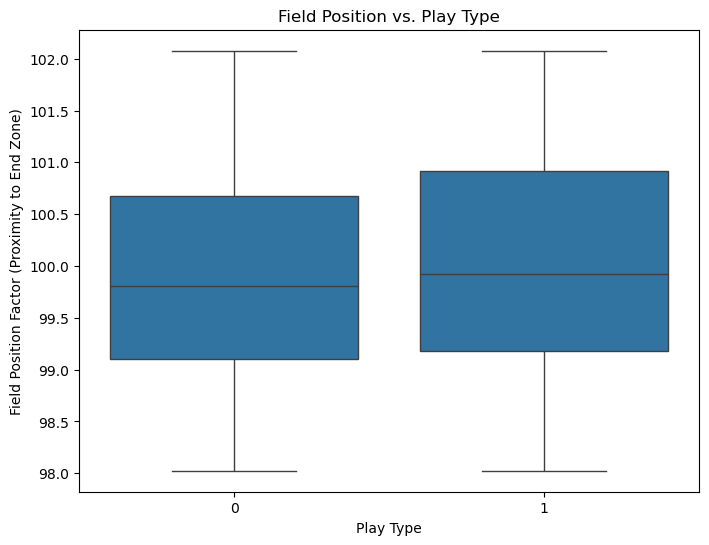

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothesis 1: Field Position vs. Play Type
plt.figure(figsize=(8, 6))
sns.boxplot(data=nfl_data, x='Play_Type', y='FIELD_POSITION_FACTOR')
plt.title('Field Position vs. Play Type')
plt.xlabel('Play Type')
plt.ylabel('Field Position Factor (Proximity to End Zone)')
plt.show()

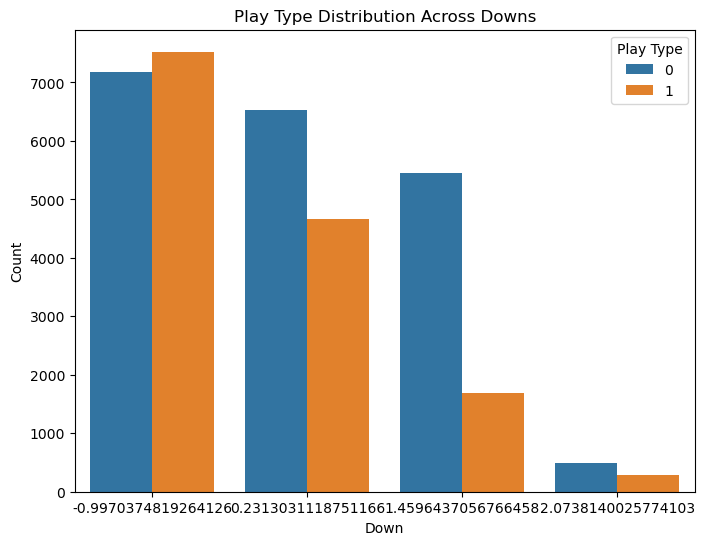

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothesis 2: Down vs. Play Type
plt.figure(figsize=(8, 6))
sns.countplot(data=nfl_data, x='DOWN', hue='Play_Type')
plt.title('Play Type Distribution Across Downs')
plt.xlabel('Down')
plt.ylabel('Count')
plt.legend(title='Play Type')
plt.show()

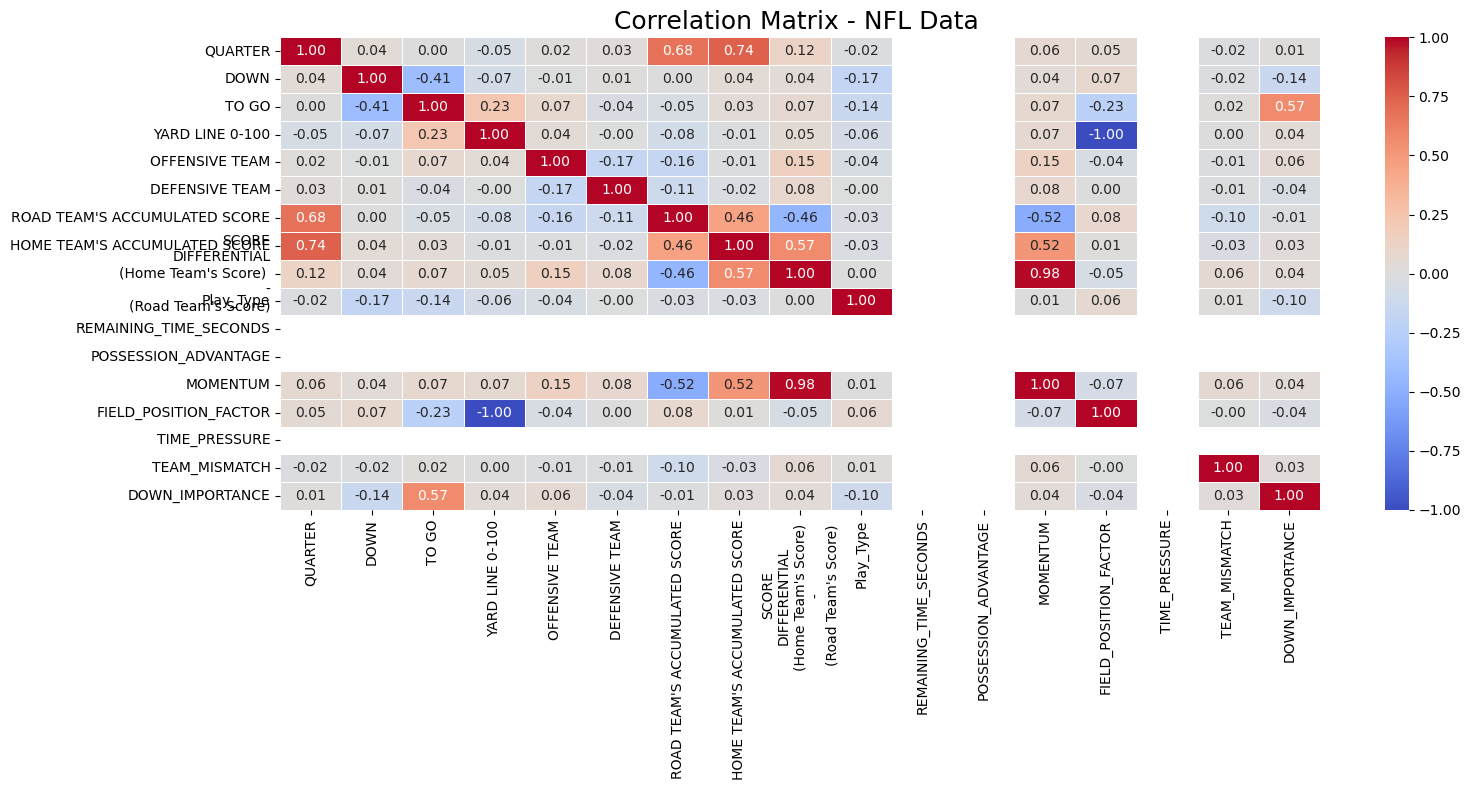

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

# Handle missing values (drop rows with missing numerical data)
numerical_columns = nfl_data.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_columns.dropna()

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    annot_kws={"size": 10}
)
plt.title("Correlation Matrix - NFL Data ", fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


Training Accuracy: 0.70


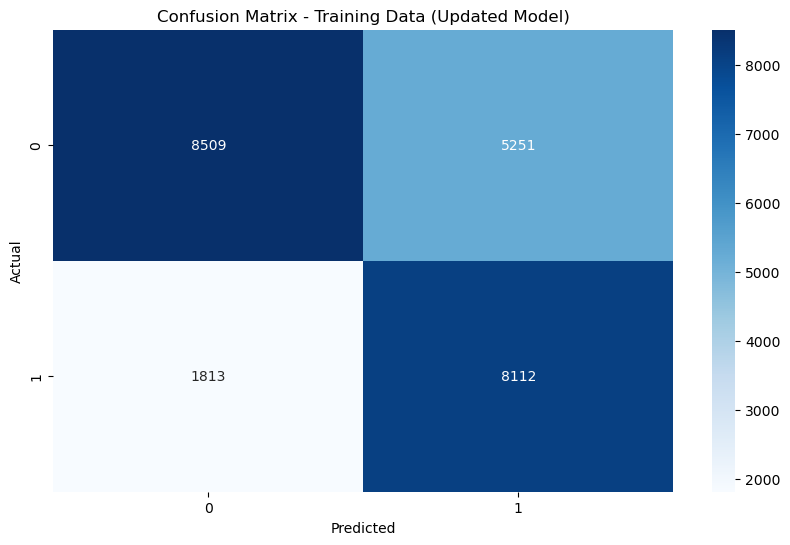

Classification Report - Training Data (Updated Model):

              precision    recall  f1-score   support

           0       0.82      0.62      0.71     13760
           1       0.61      0.82      0.70      9925

    accuracy                           0.70     23685
   macro avg       0.72      0.72      0.70     23685
weighted avg       0.73      0.70      0.70     23685



In [151]:
# Define the Random Forest model with the updated parameters
rf_model_updated = RandomForestClassifier(
    n_estimators=20,          # Reduced number of trees
    max_depth=10,             # Shallower trees for less complexity
    random_state=50,          # For reproducibility
    class_weight='balanced'   # Handle class imbalance
)

# Train the model on the training set
rf_model_updated.fit(X_train, y_train)

# Make predictions on the training set to evaluate model fit
y_train_pred_updated = rf_model_updated.predict(X_train)

# Evaluate performance on the training set
train_accuracy_updated = accuracy_score(y_train, y_train_pred_updated)
print(f"Training Accuracy: {train_accuracy_updated:.2f}")

# Confusion Matrix for Training Data
conf_matrix_train_updated = confusion_matrix(y_train, y_train_pred_updated)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_train_updated, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix - Training Data (Updated Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report for Training Data
print("Classification Report - Training Data (Updated Model):\n")
print(classification_report(y_train, y_train_pred_updated))


Feature Importance Ranking:
                                              Feature  Importance
3                                               TO GO    0.278977
2                                                DOWN    0.222692
1                                     YARD LINE 0-100    0.089725
11                                           MOMENTUM    0.063045
6                                      OFFENSIVE TEAM    0.053996
4                       ROAD TEAM'S ACCUMULATED SCORE    0.047341
7                                      DEFENSIVE TEAM    0.045735
8   SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n...    0.045601
13                                      TEAM_MISMATCH    0.045383
5                       HOME TEAM'S ACCUMULATED SCORE    0.043770
0                                             QUARTER    0.032794
10     OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral    0.030941
9                              REMAINING_TIME_SECONDS    0.000000
12                                      TIME_PRE

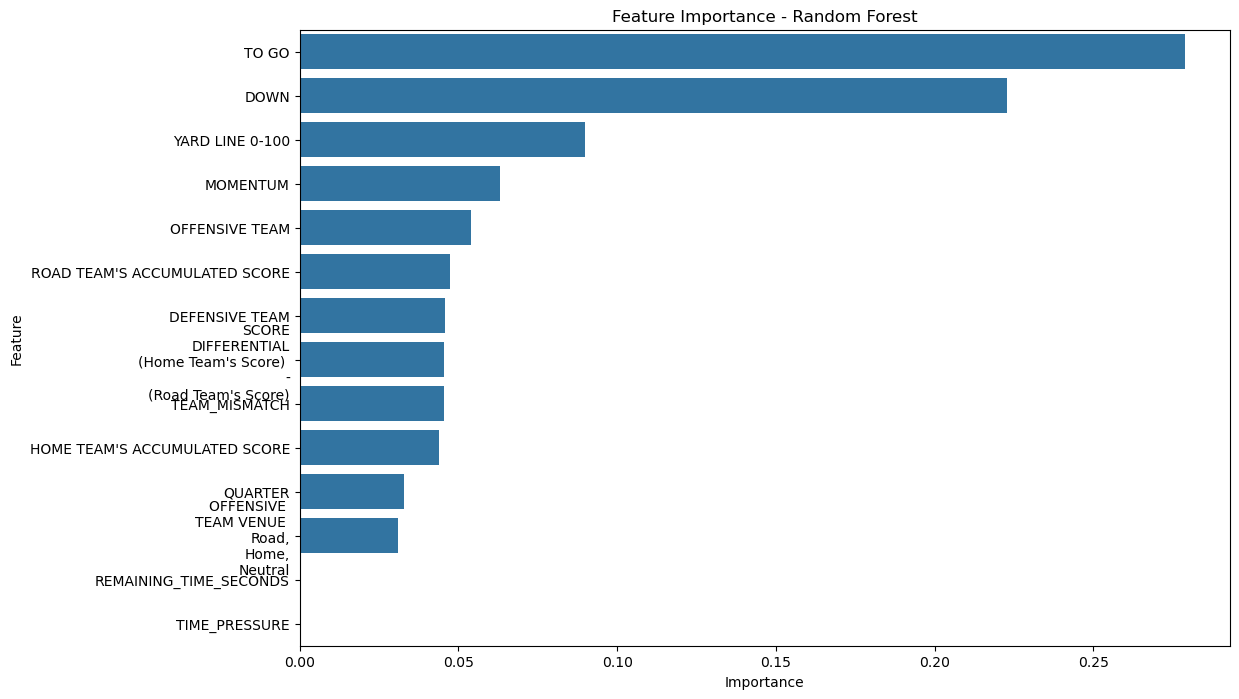

In [153]:
# Calculate feature importances from the Random Forest model
feature_importances = rf_model_updated.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importance Ranking:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Model Accuracy: 0.60


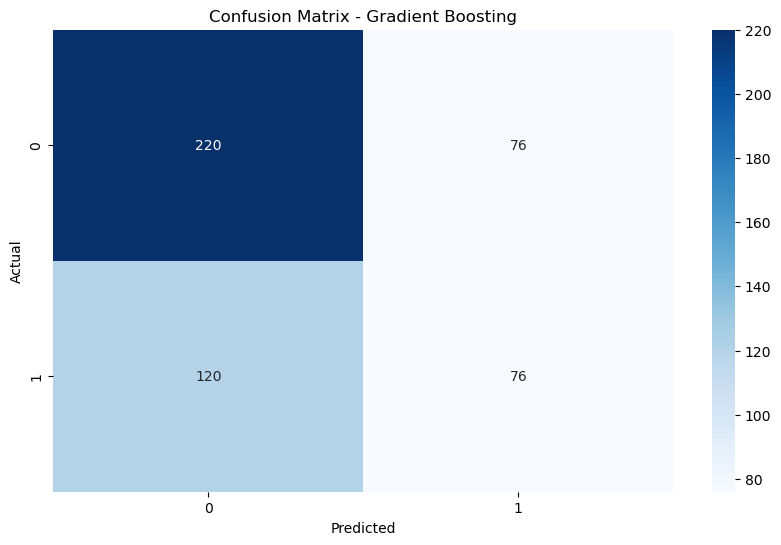

Classification Report:

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       296
           1       0.50      0.39      0.44       196

    accuracy                           0.60       492
   macro avg       0.57      0.57      0.56       492
weighted avg       0.59      0.60      0.59       492



In [175]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Features and target
features = [
    'QUARTER', 'YARD LINE 0-100', 'DOWN', 'TO GO',
    "ROAD TEAM'S ACCUMULATED SCORE", 
    "HOME TEAM'S ACCUMULATED SCORE",
    'OFFENSIVE TEAM',
    'DEFENSIVE TEAM',
    "SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score)",
    'REMAINING_TIME_SECONDS',
    'OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral', 'MOMENTUM', 'TIME_PRESSURE', 'TEAM_MISMATCH'
]
target = "Play_Type"

# Encode categorical feature
nfl_data['OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral'] = nfl_data['OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral'].astype('category').cat.codes

# Train-Test Split
X = nfl_data[features]
y = nfl_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize Gradient Boosting model with default parameters
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=gb_model.classes_, yticklabels=gb_model.classes_)
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


In [ ]:
#TEST DATA

In [83]:
# Load the test dataset into the variable `nfl_data`
nfl_data = pd.read_excel('Test_Data.xlsx')

# Display the first few rows of the dataset to confirm successful loading
nfl_data.head()


,DATE,WEEK#,ROAD TEAM,HOME TEAM,PLAY-ID,DRIVE-ID,QUARTER,REMAINING TIME IN THE QUARTER (mm:ss),DOWN,TO GO,...,SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score),Play_Type,YARDS GAINED,"PASS OUTCOME Complete,\nIncomplete,\nSack","PASS LENGTH Short,\nDeep","PASS LOCATION Left,\nMiddle,\nRight",AIR YARDS,YARDS AFTER CATCH \n(YAC),"RUN LOCATION Left,\nMiddle,\nRight","TOUCHDOWN Pass/Offensive TD,\nRush/Offensive TD,\nReturn/Defensive TD"
0,2024-01-13,19,Cleveland Browns,Houston Texans,3,1,1,15:00:00,1.0,10,...,0,Pass,11.0,Complete,short,middle,3.0,8.0,NaN,NaN
1,2024-01-13,19,Cleveland Browns,Houston Texans,4,1,1,14:37:00,1.0,10,...,0,Pass,5.0,Complete,short,left,5.0,0.0,NaN,NaN
2,2024-01-13,19,Cleveland Browns,Houston Texans,5,1,1,13:59:00,2.0,5,...,0,Run,-4.0,NaN,NaN,NaN,NaN,NaN,right,NaN
3,2024-01-13,19,Cleveland Browns,Houston Texans,6,1,1,13:17:00,3.0,9,...,0,Pass,-6.0,Complete,short,right,-6.0,0.0,NaN,NaN
4,2024-01-13,19,Cleveland Browns,Houston Texans,8,2,1,12:25:00,1.0,10,...,0,Pass,3.0,Complete,short,right,-4.0,7.0,NaN,NaN


In [85]:
nfl_data.dtypes

DATE                                                                     datetime64[ns]
WEEK#                                                                             int64
ROAD TEAM                                                                        object
HOME TEAM                                                                        object
PLAY-ID                                                                           int64
DRIVE-ID                                                                          int64
QUARTER                                                                           int64
REMAINING TIME IN THE QUARTER (mm:ss)                                            object
DOWN                                                                            float64
TO GO                                                                             int64
YARD LINE 0-100                                                                   int64
OFFENSIVE TEAM                  

In [87]:
# Check for missing values in each column
missing_values = nfl_data.isnull().sum()

# Display columns with missing values
columns_with_missing = missing_values[missing_values > 0]
print("Columns with missing values:\n", columns_with_missing)


Columns with missing values:
 DOWN                                                                        5
POINTS SCORED\nBY EITHER TEAM                                            1565
YARDS GAINED                                                              389
PASS OUTCOME Complete,\nIncomplete,\nSack                                 670
PASS LENGTH Short,\nDeep                                                  706
PASS LOCATION Left,\nMiddle,\nRight                                       706
AIR YARDS                                                                 706
YARDS AFTER CATCH \n(YAC)                                                1024
RUN LOCATION Left,\nMiddle,\nRight                                        993
TOUCHDOWN Pass/Offensive TD,\nRush/Offensive TD,\nReturn/Defensive TD    1569
dtype: int64


In [93]:
# Inspect column names in the dataset
print("Columns in the dataset:", nfl_data.columns)

# Remove only the columns that exist in the dataset
columns_to_drop = [
    'POINTS SCORED\nBY EITHER TEAM', 
    'ROAD TEAM',
    'DATE',
    'WEEK#',
    'PLAY-ID',
    'DRIVE-ID',
    'HOME TEAM',
    'YARDS GAINED',
    'PASS OUTCOME Complete,\nIncomplete,\nSack',
    'PASS LENGTH Short,\nDeep',
    'PASS LOCATION Left,\nMiddle,\nRight',
    'AIR YARDS',
    'YARDS AFTER CATCH \n(YAC)',
    'RUN LOCATION Left,\nMiddle,\nRight',
    'TOUCHDOWN Pass/Offensive TD,\nRush/Offensive TD,\nReturn/Defensive TD'
]

# Drop columns only if they exist in the dataset
existing_columns_to_drop = [col for col in columns_to_drop if col in nfl_data.columns]
nfl_data.drop(columns=existing_columns_to_drop, inplace=True)

# Confirm remaining columns
print("Remaining columns in the dataset:", nfl_data.columns)


Columns in the dataset: Index(['QUARTER', 'REMAINING TIME IN THE QUARTER (mm:ss)', 'DOWN', 'TO GO',
       'YARD LINE 0-100', 'OFFENSIVE TEAM', 'DEFENSIVE TEAM',
       'OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral',
       'ROAD TEAM'S ACCUMULATED SCORE', 'HOME TEAM'S ACCUMULATED SCORE',
       'SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score)',
       'Play_Type'],
      dtype='object')
Remaining columns in the dataset: Index(['QUARTER', 'REMAINING TIME IN THE QUARTER (mm:ss)', 'DOWN', 'TO GO',
       'YARD LINE 0-100', 'OFFENSIVE TEAM', 'DEFENSIVE TEAM',
       'OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral',
       'ROAD TEAM'S ACCUMULATED SCORE', 'HOME TEAM'S ACCUMULATED SCORE',
       'SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score)',
       'Play_Type'],
      dtype='object')


In [95]:
# Drop rows with missing values in the 'DOWN' column
nfl_data.dropna(subset=['DOWN'], inplace=True)

# Display the updated dataset
print("Updated dataset after dropping rows with missing 'DOWN' values:")
print(nfl_data.head())

# Optionally check if there are still missing values in the 'DOWN' column
missing_down = nfl_data['DOWN'].isnull().sum()
print(f"Missing values in 'DOWN' column after cleanup: {missing_down}")


Updated dataset after dropping rows with missing 'DOWN' values:
   QUARTER REMAINING TIME IN THE QUARTER (mm:ss)  DOWN  TO GO  \
0        1                              15:00:00   1.0     10   
1        1                              14:37:00   1.0     10   
2        1                              13:59:00   2.0      5   
3        1                              13:17:00   3.0      9   
4        1                              12:25:00   1.0     10   

   YARD LINE 0-100 OFFENSIVE TEAM DEFENSIVE TEAM  \
0               75            CLE            HOU   
1               64            CLE            HOU   
2               59            CLE            HOU   
3               63            CLE            HOU   
4               83            HOU            CLE   

  OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral  \
0                                           Road   
1                                           Road   
2                                           Road   
3                       

In [97]:
import pandas as pd

# Function to detect outliers using the IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

# Identify numerical columns
numerical_columns = nfl_data.select_dtypes(include=['float64', 'int64']).columns

# Check for outliers in all numerical columns
outliers_summary = []
for column in numerical_columns:
    outlier_count, lower_bound, upper_bound = detect_outliers_iqr(nfl_data, column)
    outliers_summary.append({
        'Column': column,
        'Outlier Count': outlier_count,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    })

# Convert the summary into a DataFrame for better visualization
outliers_df = pd.DataFrame(outliers_summary)

# Display the summary DataFrame
print("Outlier Summary:")
print(outliers_df)


Outlier Summary:
                                              Column  Outlier Count  \
0                                            QUARTER              0   
1                                               DOWN             40   
2                                              TO GO             41   
3                                    YARD LINE 0-100              0   
4                      ROAD TEAM'S ACCUMULATED SCORE             46   
5                      HOME TEAM'S ACCUMULATED SCORE              0   
6  SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n...            124   

   Lower Bound  Upper Bound  
0         -1.0          7.0  
1         -0.5          3.5  
2          0.0         16.0  
3        -26.5        129.5  
4        -18.0         38.0  
5        -24.0         48.0  
6        -18.0         22.0  


In [99]:
# Function to handle outliers using capping
def cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap the outliers
    data[column] = data[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

# Identify numerical columns
numerical_columns = nfl_data.select_dtypes(include=['float64', 'int64']).columns

# Handle outliers for columns with significant outliers
for column in numerical_columns:
    outlier_count, _, _ = detect_outliers_iqr(nfl_data, column)
    if outlier_count > 0:  # Only process columns with outliers
        cap_outliers(nfl_data, column)

# Verify changes by re-checking for outliers
outliers_summary_after_capping = []
for column in numerical_columns:
    outlier_count, lower_bound, upper_bound = detect_outliers_iqr(nfl_data, column)
    outliers_summary_after_capping.append({
        'Column': column,
        'Outlier Count': outlier_count,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    })

# Convert the updated summary into a DataFrame
outliers_df_after_capping = pd.DataFrame(outliers_summary_after_capping)

# Display the updated outlier summary
print("Outlier Summary After Capping:")
print(outliers_df_after_capping)


Outlier Summary After Capping:
                                              Column  Outlier Count  \
0                                            QUARTER              0   
1                                               DOWN              0   
2                                              TO GO              0   
3                                    YARD LINE 0-100              0   
4                      ROAD TEAM'S ACCUMULATED SCORE              0   
5                      HOME TEAM'S ACCUMULATED SCORE              0   
6  SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n...              0   

   Lower Bound  Upper Bound  
0         -1.0          7.0  
1         -0.5          3.5  
2          0.0         16.0  
3        -26.5        129.5  
4        -18.0         38.0  
5        -24.0         48.0  
6        -18.0         22.0  


In [121]:
# Inspect the column names
print("Columns in the dataset:", nfl_data.columns)

# Update the column reference
time_column = 'REMAINING TIME IN THE QUARTER (mm:ss)'  # Replace with the correct column name if different

# Check if the time column exists
if time_column in nfl_data.columns:
    # Preprocess the time column to ensure all values are strings
    nfl_data[time_column] = nfl_data[time_column].astype(str)

    # Define a function to safely convert to seconds
    def safe_time_to_seconds(time_str):
        try:
            # Ensure the string is in 'mm:ss' format and split it
            parts = time_str.split(':')
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes * 60 + seconds
        except (ValueError, IndexError):
            return None  # Handle invalid formats gracefully

    # Apply the function to convert time to seconds
    nfl_data['REMAINING_TIME_SECONDS'] = nfl_data[time_column].apply(safe_time_to_seconds)

    # Drop the original time column if no longer needed
    nfl_data.drop(columns=[time_column], inplace=True)

    # Display the updated dataset
    print("Updated Dataset with Time in Seconds:")
    print(nfl_data.head())
else:
    print(f"Column '{time_column}' not found in the dataset.")


Columns in the dataset: Index(['QUARTER', 'DOWN', 'TO GO', 'YARD LINE 0-100', 'OFFENSIVE TEAM',
       'DEFENSIVE TEAM', 'OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral',
       'ROAD TEAM'S ACCUMULATED SCORE', 'HOME TEAM'S ACCUMULATED SCORE',
       'SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score)',
       'Play_Type', 'REMAINING_TIME_SECONDS'],
      dtype='object')
Column 'REMAINING TIME IN THE QUARTER (mm:ss)' not found in the dataset.


In [125]:
nfl_data.head

<bound method NDFrame.head of       QUARTER  DOWN  TO GO  YARD LINE 0-100 OFFENSIVE TEAM DEFENSIVE TEAM  \
0           1   1.0   10.0               75            CLE            HOU   
1           1   1.0   10.0               64            CLE            HOU   
2           1   2.0    5.0               59            CLE            HOU   
3           1   3.0    9.0               63            CLE            HOU   
4           1   1.0   10.0               83            HOU            CLE   
...       ...   ...    ...              ...            ...            ...   
1638        5   2.0    6.0               37             KC             SF   
1639        5   3.0    1.0               32             KC             SF   
1640        5   1.0   10.0               13             KC             SF   
1641        5   2.0    7.0               10             KC             SF   
1642        5   1.0    3.0                3             KC             SF   

     OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nN

In [127]:
from sklearn.preprocessing import LabelEncoder

# Automatically detect all categorical columns
categorical_columns = nfl_data.select_dtypes(include=['object', 'category']).columns

# Exclude 'REMAINING TIME IN THE QUARTER (mm:ss)' if present
excluded_column = 'REMAINING TIME IN THE QUARTER (mm:ss)'
categorical_columns = [col for col in categorical_columns if col != excluded_column]

# Apply LabelEncoder to each remaining categorical column
label_encoders = {}  # To store LabelEncoders for each column (optional, for inverse transformation)
for column in categorical_columns:
    le = LabelEncoder()
    nfl_data[column] = le.fit_transform(nfl_data[column].astype(str))
    label_encoders[column] = le  # Store the encoder for potential inverse transformation

# Display the updated dataset
print("Updated dataset after encoding categorical columns:")
print(nfl_data.head())


Updated dataset after encoding categorical columns:
   QUARTER  DOWN  TO GO  YARD LINE 0-100  OFFENSIVE TEAM  DEFENSIVE TEAM  \
0        1   1.0   10.0               75               2               6   
1        1   1.0   10.0               64               2               6   
2        1   2.0    5.0               59               2               6   
3        1   3.0    9.0               63               2               6   
4        1   1.0   10.0               83               6               2   

   OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral  \
0                                               1   
1                                               1   
2                                               1   
3                                               1   
4                                               0   

   ROAD TEAM'S ACCUMULATED SCORE  HOME TEAM'S ACCUMULATED SCORE  \
0                            0.0                              0   
1                            0.0      

In [129]:
from sklearn.preprocessing import StandardScaler

# Manually specify the numerical columns
numerical_columns = [
    'QUARTER', 'YARD LINE 0-100', 'DOWN', 'TO GO',
    "ROAD TEAM'S ACCUMULATED SCORE", 
    "HOME TEAM'S ACCUMULATED SCORE",
    'SCORE\nDIFFERENTIAL\n(Home Team\'s Score) \n-\n(Road Team\'s Score)', 
    'REMAINING_TIME_SECONDS', 'MOMENTUM', 'TEAM_MISMATCH'
]

# Ensure that all specified columns exist in the dataset
numerical_columns = [col for col in numerical_columns if col in nfl_data.columns]

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the manually specified numerical columns
nfl_data[numerical_columns] = scaler.fit_transform(nfl_data[numerical_columns])

# Display the standardized dataset
print("Dataset after standardizing numerical columns:")
print(nfl_data.head())


Dataset after standardizing numerical columns:
    QUARTER      DOWN     TO GO  YARD LINE 0-100  OFFENSIVE TEAM  \
0 -1.370978 -0.970703  0.494848         1.052239               2   
1 -1.370978 -0.970703  0.494848         0.588880               2   
2 -1.370978  0.270524 -0.947945         0.378263               2   
3 -1.370978  1.511750  0.206290         0.546757               2   
4 -1.370978 -0.970703  0.494848         1.389227               6   

   DEFENSIVE TEAM  OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral  \
0               6                                               1   
1               6                                               1   
2               6                                               1   
3               6                                               1   
4               2                                               0   

   ROAD TEAM'S ACCUMULATED SCORE  HOME TEAM'S ACCUMULATED SCORE  \
0                      -1.218379                      -1.24778

In [131]:
import numpy as np

# Feature 1: Possession Advantage
nfl_data['POSSESSION_ADVANTAGE'] = (nfl_data['OFFENSIVE \nTEAM VENUE \nRoad,\nHome,\nNeutral'] == 'Home').astype(int)

# Feature 2: Momentum (Score Differential)
nfl_data['MOMENTUM'] = nfl_data["HOME TEAM'S ACCUMULATED SCORE"] - nfl_data["ROAD TEAM'S ACCUMULATED SCORE"]

# Feature 3: Field Position Factor
nfl_data['FIELD_POSITION_FACTOR'] = 100 - nfl_data['YARD LINE 0-100']

# Feature 4: Time Pressure Index
nfl_data['TIME_PRESSURE'] = 1 / (nfl_data['REMAINING_TIME_SECONDS'] + 1)  # Adding 1 to avoid division by zero

# Feature 5: Offense vs. Defense Indicator
nfl_data['TEAM_MISMATCH'] = np.abs(nfl_data['OFFENSIVE TEAM'] - nfl_data['DEFENSIVE TEAM'])

# Feature 6: Down Importance
nfl_data['DOWN_IMPORTANCE'] = nfl_data['DOWN'] * nfl_data['TO GO']

# View the resulting DataFrame with new features
print(nfl_data[['POSSESSION_ADVANTAGE', 'MOMENTUM', 'FIELD_POSITION_FACTOR', 
                'TIME_PRESSURE', 'TEAM_MISMATCH', 'DOWN_IMPORTANCE']].head())


   POSSESSION_ADVANTAGE  MOMENTUM  FIELD_POSITION_FACTOR  TIME_PRESSURE  \
0                     0 -0.029409              98.947761            1.0   
1                     0 -0.029409              99.411120            1.0   
2                     0 -0.029409              99.621737            1.0   
3                     0 -0.029409              99.453243            1.0   
4                     0 -0.029409              98.610773            1.0   

   TEAM_MISMATCH  DOWN_IMPORTANCE  
0              4        -0.480351  
1              4        -0.480351  
2              4        -0.256442  
3              4         0.311858  
4              4        -0.480351  


Test Accuracy: 0.73


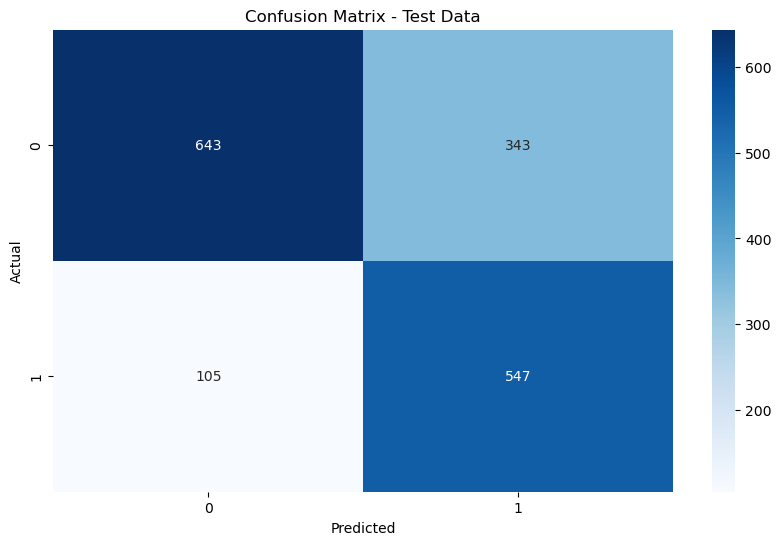

Classification Report - Test Data:

              precision    recall  f1-score   support

           0       0.86      0.65      0.74       986
           1       0.61      0.84      0.71       652

    accuracy                           0.73      1638
   macro avg       0.74      0.75      0.73      1638
weighted avg       0.76      0.73      0.73      1638



In [155]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define the Random Forest model with slight adjustments
rf_model_adjusted = RandomForestClassifier(
    n_estimators=20,          # Slightly increased number of trees
    max_depth=8,              # Allow slightly deeper trees
    min_samples_split=4,      # Allow earlier splits
    min_samples_leaf=3,       # Keep leaf nodes simple
    random_state=50,          # For reproducibility
    class_weight='balanced'   # Handle class imbalance
)

# Step 1: Extract features and target variable from the test dataset
features = [
    'QUARTER', 'YARD LINE 0-100', 'DOWN', 'TO GO',
    "ROAD TEAM'S ACCUMULATED SCORE", 
    "HOME TEAM'S ACCUMULATED SCORE",
    "SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n(Road Team's Score)",
    'REMAINING_TIME_SECONDS', 'POSSESSION_ADVANTAGE', 'MOMENTUM', 
    'FIELD_POSITION_FACTOR', 'TIME_PRESSURE', 'TEAM_MISMATCH', 'DOWN_IMPORTANCE'
]
X_test = nfl_data[features]
y_test = nfl_data['Play_Type']

# Step 2: Train the adjusted Random Forest model on the test dataset
rf_model_adjusted.fit(X_test, y_test)

# Step 3: Make predictions on the test dataset
y_test_pred = rf_model_adjusted.predict(X_test)

# Step 4: Evaluate the performance of the model on the test dataset
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Step 5: Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 6: Classification Report
print("Classification Report - Test Data:\n")
print(classification_report(y_test, y_test_pred))



Feature Importances for Test Data Random Forest:
                                              Feature  Importance
13                                    DOWN_IMPORTANCE    0.178672
3                                               TO GO    0.131948
10                              FIELD_POSITION_FACTOR    0.123029
2                                                DOWN    0.100344
1                                     YARD LINE 0-100    0.098769
9                                            MOMENTUM    0.088210
5                       HOME TEAM'S ACCUMULATED SCORE    0.074154
6   SCORE\nDIFFERENTIAL\n(Home Team's Score) \n-\n...    0.069156
4                       ROAD TEAM'S ACCUMULATED SCORE    0.064369
12                                      TEAM_MISMATCH    0.041820
0                                             QUARTER    0.029529
7                              REMAINING_TIME_SECONDS    0.000000
8                                POSSESSION_ADVANTAGE    0.000000
11                        

/var/folders/3k/vpbyp6v12x97811z_5br1k480000gn/T/ipykernel_28533/2751402910.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")


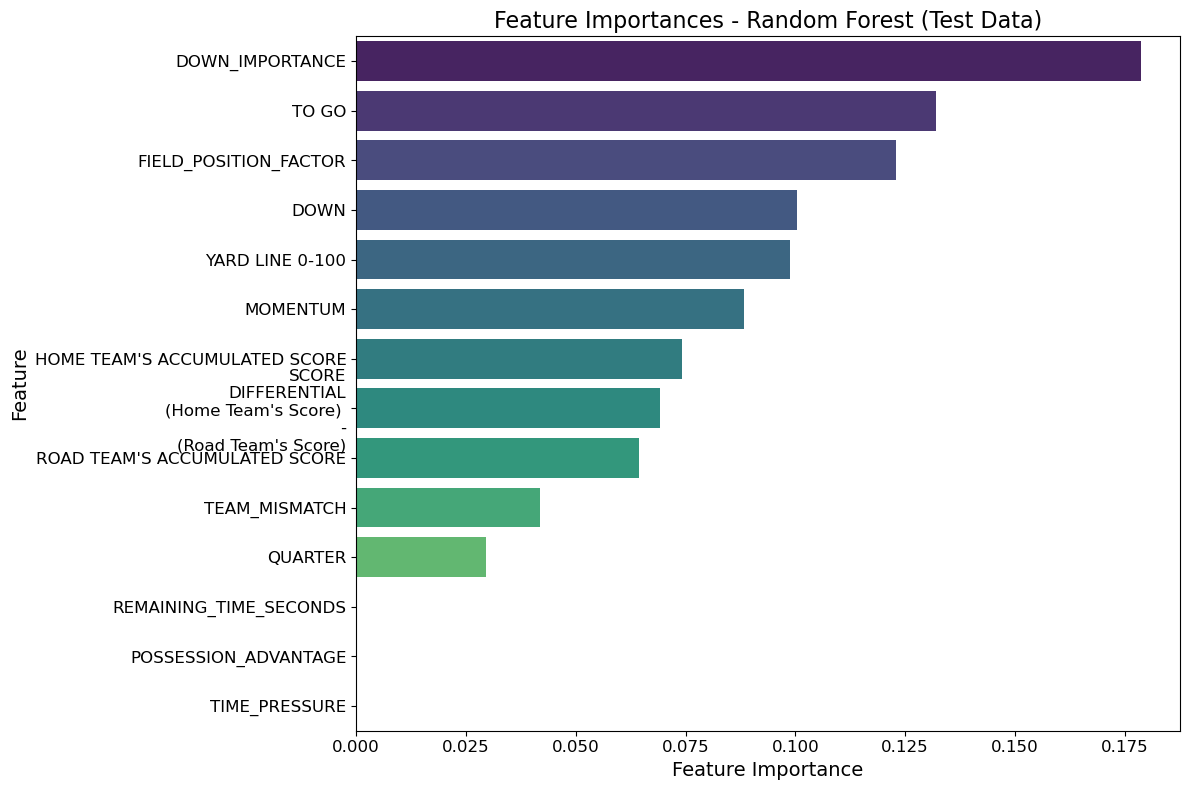

In [157]:
# Calculate Feature Importances
feature_importances = rf_model_adjusted.feature_importances_

#Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

#  Display the feature importances
print("\nFeature Importances for Test Data Random Forest:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title('Feature Importances - Random Forest (Test Data)', fontsize=16)
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()